## **Configuração do Ambiente**

In [ ]:
!pip install torch torchvision torchaudio
!pip install yolov5
!pip install scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Caminho do dataset
dataset = '/content/drive/MyDrive/rsna-breast-cancer-detection'

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Verifica se CUDA (GPU) está disponível
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA disponível. Usando GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA não está disponível. Usando CPU.")


## **Leitura, Mapeamento e Tratamento (Normalização) das Imagens**

In [ ]:
# Leitura do arquivo CSV
train_csv_path = os.path.join(dataset, 'train.csv')
train_df = pd.read_csv(train_csv_path)

print(train_df['cancer'].value_counts())  # Verifica a contagem dos valores na coluna 'cancer'

In [ ]:
def map_label(cancer_status):
    return cancer_status  # Retorna o valor original, 0 ou 1

train_df['label'] = train_df['cancer'].apply(map_label)


print(train_df['label'].value_counts())

In [ ]:
# Construir o caminho da imagem
def construir_caminho_imagem(row):
    return os.path.join(dataset, 'train_images', f"{row['patient_id']}@{row['image_id']}.png")

train_df['image file path'] = train_df.apply(construir_caminho_imagem, axis=1)

# Divisão dos dados em treinamento, validação e teste
train_df, temp_df = train_test_split(train_df, test_size=0.3, stratify=train_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [ ]:
# Contagem dos exemplos com e sem câncer em cada conjunto
train_cancer_count = train_df['label'].sum()
train_no_cancer_count = len(train_df) - train_cancer_count

val_cancer_count = val_df['label'].sum()
val_no_cancer_count = len(val_df) - val_cancer_count

test_cancer_count = test_df['label'].sum()
test_no_cancer_count = len(test_df) - test_cancer_count

# Exibição da tabela
print(f"{'Conjunto':<15} | {'Tamanho':<10} | {'Com Câncer':<11} | {'Sem Câncer':<11}")
print(f"{'-'*55}")
print(f"{'Treinamento':<15} | {len(train_df):<10} | {train_cancer_count:<11} | {train_no_cancer_count:<11}")
print(f"{'Validação':<15} | {len(val_df):<10} | {val_cancer_count:<11} | {val_no_cancer_count:<11}")
print(f"{'Teste':<15}     | {len(test_df):<10} | {test_cancer_count:<11} | {test_no_cancer_count:<11}")


In [ ]:
# Preparar os dados para treinamento
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image file path']
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"Imagem não encontrada: {img_path}")

        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Falha ao carregar a imagem: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        label = self.dataframe.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Defina as transformações de normalização para as imagens
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Crie os datasets utilizando os dataframes previamente criados
train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

# Crie os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

## **Definição e Treinamento da CNN**

Entrada (Imagem RGB): 416x416x3 = 518.784 neurônios.

---

Conv1: 32 filtros de 3x3, saída: 416x416x32 = 5.537.792 neurônios.

MaxPool: kernel 2x2, saída: 208x208x32 = 1.384.448 neurônios.

---

Conv2: 64 filtros de 3x3, saída: 208x208x64 = 2.768.896 neurônios.

MaxPool: kernel 2x2, saída: 104x104x64 = 692.224 neurônios.

---

Conv3: 128 filtros de 3x3, saída: 104x104x128 = 1.384.448 neurônios.

MaxPool: kernel 2x2, saída: 52x52x128 = 346.112 neurônios.

---

Flatten: 52*52*128 = 346,112 neurônios

---

FC1: 512 neurônios, ativação ReLU

FC2: 256 neurônios, ativação ReLU

FC3: 128 neurônios, ativação ReLU

FC4: 64 neurônios, ativação ReLU

FC5: 1 neurônio, ativação Sigmoide

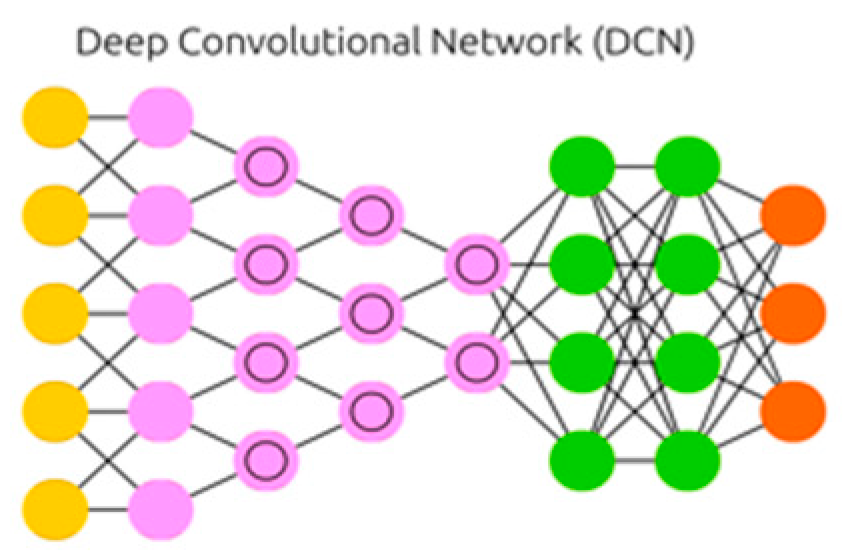

In [ ]:
class ConvolutionalNN(nn.Module):
    def __init__(self):
        super(ConvolutionalNN, self).__init__()
        # Camadas convolucionais
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Camadas de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Camadas totalmente conectadas
        self.fc1 = nn.Linear(128 * 52 * 52, 512)   # Ajustar o tamanho conforme a saída do pooling
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)                 # Camada de saída

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Aplicar convolução e pooling
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 52 * 52)  # Achatar a saída das camadas convolucionais
        x = F.relu(self.fc1(x))          # Camadas totalmente conectadas
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))  # Camada de saída com sigmoide
        return x

In [ ]:
# Definir o modelo de treinamento
model = ConvolutionalNN().to(device)

In [ ]:
# Definir o critério de perda e o otimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Treinamento
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

## Avaliação de desempenho da rede neural

In [ ]:
# Monitoramento de uso da GPU
print(f"Memória total disponível na GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"Memória usada: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Memória livre: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

In [ ]:
model.eval()  # Set model to evaluation mode
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = torch.round(outputs.squeeze())  # Assuming binary classification
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

In [ ]:
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate Acurracy
accuracy = np.sum(all_labels == all_predictions) / len(all_labels) * 100

# Generate the confusion matrix, ensuring it is 2x2
cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
fig, ax = plt.subplots()

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, values_format='')
plt.title('Matriz de Confusão')
plt.figtext(0.5, -0.2, f'Acurácia: {accuracy:.2f}%', fontsize=12, ha='center', va='center', transform=ax.transAxes)
plt.show()